# Laboratorium 4 - rekomendacje dla portali informacyjnych

## Przygotowanie

 * pobierz i wypakuj dataset: https://mind201910small.blob.core.windows.net/release/MINDsmall_train.zip
   * więcej możesz poczytać tutaj: https://learn.microsoft.com/en-us/azure/open-datasets/dataset-microsoft-news
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab4`
 * zainstaluj potrzebne biblioteki:
 `pip install nltk sklearn`

## Część 1. - przygotowanie danych

In [1]:
# importujemy wszystkie potrzebne pakiety

import math
import re
from string import punctuation
from itertools import chain
from collections import defaultdict # mozesz uzyc zamiast zwyklego slownika, rozwaz wplyw na czas obliczen
import codecs
from typing import Literal, TypedDict

import nltk
nltk.download('stopwords', download_dir="./data/")

from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

# mozesz uzyc do obliczania najbardziej podobnych tekstow zamiast liczenia "na piechote"
# ale pamietaj o dostosowaniu formatu danych
from sklearn.neighbors import NearestNeighbors

# na potrzeby wizualizacji
import matplotlib.pyplot as plt
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to ./data/...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# definiujemy potrzebne zmienne

PATH = './lab-files/MINDsmall_train'
STOPWORDS = set(stopwords.words('english'))
METRIC = 'cosine'

In [3]:
# wczytujemy metadane artykułów

NewsEntry = TypedDict('NewsEntry', {
    'news_id': str,
    'category': str,
    'subcategory': str,
    'title': str,
    'abstract': str
})


def parse_news_entry(entry: str) -> NewsEntry:
    news_id, category, subcategory, title, abstract = entry.split('\t')[:5]
    return {
        'news_id': news_id,
        'category': category,
        'subcategory': subcategory,
        'title': title,
        'abstract': abstract
    }


def get_news_metadata() -> dict[str, NewsEntry]:
    with codecs.open(f'{PATH}/news.tsv', 'r', 'UTF-8') as f:
        raw = [x for x in f.read().split('\n') if x]
        parsed_entries = [parse_news_entry(entry) for entry in raw]
        return {x['news_id']: x for x in parsed_entries}


news: dict[str, NewsEntry] = get_news_metadata()
news_ids: list[str] = sorted(list(news.keys()))
news_indices: dict[str, int] = {x[1]: x[0] for x in enumerate(news_ids)}
print(len(news))

51282


In [4]:
def parse_history_entry(entry: str) -> tuple[str, list[str]]:
    _id, user_id, _time, history, _impressions = entry.split('\t')
    history = [x for x in history.split() if x]
    return user_id, history


def get_users_history() -> dict[str, list[str]]:
    with codecs.open(f'{PATH}/behaviors.tsv', 'r', 'UTF-8') as f:
        lines = [x for x in f.read().split('\n') if x]
        entries = [parse_history_entry(x) for x in lines]
        return dict(entries)


users_history = get_users_history()
test_users = 'U53231', 'U89744', 'U10045', 'U92486', 'U70879'
print(len(users_history))

50000


## Część 2. - TF-IDF

In [5]:
# normalizujemy teksty na potrzeby dalszego przetwarzania

def preprocess_text(text: str) -> list[str]:
    # zamieniamy wszystkie ciagi bialych znakow na pojedyncze spacje
    # usuwamy znaki interpunkcyjne
    # usuwamy wszystkie liczby
    # podmieniamy wszystkie wielkie litery
    # dzielimy na tokeny
    # usuwamy stopwords

    text = re.sub(r'\s+', ' ', text)
    text = text.translate(str.maketrans('', '', punctuation))
    text = re.sub(r'\d+', '', text)
    text = text.lower()

    tokens: list[str] = text.split()
    tokens = [token for token in tokens if token not in STOPWORDS]

    return tokens


def stem_texts(corpus: list[str]) -> list[list[str]]:
    # stemmer = LancasterStemmer()
    # stemmer = PorterStemmer()
    stemmer = SnowballStemmer(language='english')
    return [
        [stemmer.stem(word) for word in preprocess_text(text)]
        for text in corpus
    ]


texts = [news[news_id]['abstract'] for news_id in news_ids]
stemmed_texts = stem_texts(texts)

In [6]:
# porownajmy teksty przed i po przetworzeniu

print(texts[2] + '\n')
print(' '.join(stemmed_texts[2]))

"I think we have a really good team, and a team that can really do some special, good things because that group is very close in there." - Brian Schmetzer

think realli good team team realli special good thing group close brian schmetzer


In [7]:
# tworzymy liste wszystkich slow w korpusie

def get_all_words_sorted(corpus: list[list[str]]) -> list[str]:
    # generujemy posortowana alfabetycznie liste wszystkich slow (tokenow)
    unique_tokens: set[str] = {token for tokens in corpus for token in tokens}
    return sorted(list(unique_tokens))


wordlist = get_all_words_sorted(stemmed_texts)
word_indices = {x[1]: x[0] for x in enumerate(wordlist)}
print(len(wordlist))

41849


In [8]:
# obliczamy liczbe tekstow, w ktorych wystapilo kazde ze slow
# pamietaj, ze jesli slowo wystapilo w danym tekscie wielokrotnie, to liczymy je tylko raz

def get_document_frequencies(
    corpus: list[list[str]],
    wordlist: list[str]
) -> dict[str, int]:
    # return {word -> count}

    document_frequency: defaultdict[str, int] = defaultdict(int)
    for text in corpus:
        unique_words = set(text)
        for word in unique_words:
            document_frequency[word] += 1

    return document_frequency


document_frequency = get_document_frequencies(stemmed_texts, wordlist)

In [9]:
# obliczamy liczbe wystapien kazdego slowa w kazdym tekscie

def get_term_frequencies(
    corpus: list[list[str]],
    news_indices: dict[str, int]
) -> dict[str, dict[str, int]]:
    # return {news_id -> {word -> count}}

    term_frequency: dict[str, dict[str, int]] = {}

    for news_id, text in zip(news_indices.keys(), corpus):
        document_frequency: defaultdict[str, int] = defaultdict(int)
        for word in text:
            document_frequency[word] += 1
        term_frequency[news_id] = document_frequency

    return term_frequency


term_frequency = get_term_frequencies(stemmed_texts, news_indices)

In [10]:
# sprawdzmy wyniki

term_frequency[news_ids[2]]

defaultdict(int,
            {'think': 1,
             'realli': 2,
             'good': 2,
             'team': 2,
             'special': 1,
             'thing': 1,
             'group': 1,
             'close': 1,
             'brian': 1,
             'schmetzer': 1})

In [11]:
# obliczamy metryke tf_idf

def calculate_tf_idf(
    term_frequency: dict[str, dict[str, int]],
    document_frequency: dict[str, int],
    corpus_size: int
) -> dict[str, dict[str, float]]:
    # return {news_id -> {word -> tf_idf}}

    tf_idf: dict[str, dict[str, float]] = {}

    for news_id, term_freq in term_frequency.items():
        document_idf: dict[str, float] = {}
        for word, freq in term_freq.items():
            document_idf[word] \
                = freq * math.log(corpus_size / document_frequency[word])
        tf_idf[news_id] = document_idf

    return tf_idf


tf_idf = calculate_tf_idf(term_frequency, document_frequency, len(news_ids))

In [12]:
# sprawdzmy wyniki

tf_idf[news_ids[2]]

{'think': 4.360459856758821,
 'realli': 9.707261090572182,
 'good': 8.085400658139525,
 'team': 6.157356388748834,
 'special': 4.765161897298483,
 'thing': 4.111693200556713,
 'group': 4.261685870235309,
 'close': 3.9244235881453897,
 'brian': 5.624739267315748,
 'schmetzer': 9.458800731274183}

## Część 3. - Podobieństwo tekstów

In [13]:
def cosine_similarity(v1: dict[str, float], v2: dict[str, float]) -> float:
    if len(v1) == 0 or len(v2) == 0:
        return -1.0

    unique_words: set[str] = set(chain(v1.keys(), v2.keys()))

    dot_product: int = sum(
        [v1.get(word, 0.0) * v2.get(word, 0.0) for word in unique_words]
    )
    a_length: float = math.sqrt(sum([v**2 for v in v1.values()]))
    b_length: float = math.sqrt(sum([v**2 for v in v2.values()]))

    return dot_product / (a_length * b_length)

In [14]:
# obliczmy odleglosc miedzy dwoma artykulami
# przetestuj rozne metryki odleglosci i wybierz najlepsza

def calculate_vector_distance(
    v1: dict[str, float],
    v2: dict[str, float],
    metric: Literal['euclidean', 'cosine']
) -> float:
    if metric == 'euclidean':
        if len(v1) == 0 or len(v2) == 0:
            return math.inf

        return math.sqrt(sum([
            (v1.get(word, 0) - v2.get(word, 0))**2
            for word in set(chain(v1.keys(), v2.keys()))
        ]))
    elif metric == 'cosine':
        return 1 - cosine_similarity(v1, v2)

    raise ValueError(f'Unknown metric: {metric}')

def calculate_distance(
    tf_idf: dict[str, dict[str, float]],
    id1: str,
    id2: str,
    metric: Literal['euclidean', 'cosine'] = 'euclidean'
) -> float:
    return calculate_vector_distance(tf_idf[id1], tf_idf[id2], metric)


calculate_distance(tf_idf, news_ids[2], news_ids[1], METRIC)

0.9752927736617004

In [15]:
# funkcja pomocnicza do wyswietlania artykulow
def print_news_entry(n_id: str, corpus: dict[str, NewsEntry]) -> None:
    print(f'id: {n_id}\n\ttitle: {corpus[n_id]["title"]}\n\ttext: {corpus[n_id]["abstract"]}')


print_news_entry('N42782', news)

id: N42782
	title: Three takeaways from Yankees' ALCS Game 5 victory over the Astros
	text: The Yankees kept hope alive thanks to some impressive starting pitching and a pair of early home runs.


In [16]:
# wyznaczmy k najpodobniejszych tekstow do danego
# pamietaj o odpowiedniej kolejnosci sortowania w zaleznosci od wykorzystanej metryki
# pamietaj, zeby wsrod podobnych tekstow nie bylo danego

def get_k_most_similar_news(
    tf_idf: dict[str, dict[str, float]],
    n_id: str,
    metric: Literal['euclidean', 'cosine'],
    k: int
) -> list[str]:
    # Bez `n_id`.
    news_ids: filter[str] = filter(lambda i: i != n_id, tf_idf.keys())

    distances: list[tuple[float, str]] = [
        (calculate_distance(tf_idf, n_id, other_id, metric), other_id)
        for other_id in news_ids
    ]
    distances.sort()

    return list(map(lambda d: d[1], distances[:k]))


def print_k_most_similar_news(
    tf_idf: dict[str, dict[str, float]],
    n_id: str,
    metric: Literal['euclidean', 'cosine'],
    k: int,
    corpus: dict[str, NewsEntry]
) -> None:
    similar = get_k_most_similar_news(tf_idf, n_id, metric, k)
    print_news_entry(n_id, corpus)
    print(f'\n{k} most similar:')
    for s_id in similar:
       print_news_entry(s_id, corpus)


print_k_most_similar_news(tf_idf, news_ids[42337], METRIC, k=5, corpus=news)

id: N58544
	title: Tiny Electric Car Cost $420,000 To Build
	text: A MAN claims he has created a car that might solve the world's traffic congestion problems. Rick Woodbury from Spokane, Washington USA, is the president, founder and sole employee of 'Commuter Cars.' The carmaker's flagship model is the 2005 super slim two-seater Tango T600, a high-performance electric car that preceded Tesla. Rick told BTV: "I started this company 21 years ago   it was based on an idea that I came up with in 1982." He was inspired by the shocking traffic congestion he had to face on a daily basis. "I used to drive a Porsche from Beverly Hills to Hermosa Beach every day and the traffic was horrendous," explained Rick. What really made Rick think about a solution was the fact that in most of the cars he would see in his commute were occupied by lone drivers. "I noticed that everybody around me was a single occupant in a car, taking up the whole lane," Rick said. Living and working in Los Angeles also hel

## Część 4. - Profile użytkowników

In [17]:
# oblicz srednia z wektorow tf-idf artykulow o zadanych id-kach
def calculate_average_vector(
    tf_idf: dict[str, dict[str, float]],
    news_ids: list[str]
) -> dict[str, float]:
    cumulative_vector: defaultdict[str, float] = defaultdict(float)
    for n_id in news_ids:
        for word, idf in tf_idf[n_id].items():
            cumulative_vector[word] += idf

    average_vector: dict[str, float] = {
        word: cumulation / len(news_ids)
        for word, cumulation in cumulative_vector.items()
    }

    return average_vector


# wykorzystaj powyzsza funkcje, by policzyc wektor kazdego uzytkownika
def calculate_users_vectors(
    tf_idf: dict[str, dict[str, float]],
    users_history: dict[str, list[str]]
) -> dict[str, dict[str, float]]:
    return {
        user_id: calculate_average_vector(tf_idf, user_entries)
        for user_id, user_entries in users_history.items()
    }


user_vectors: dict[str, dict[str, float]] = calculate_users_vectors(
    tf_idf, users_history
)

In [18]:
# sprawdz wyliczony profil dla przykladowego uzytkownika
print(sorted(
    [(k, v) for k, v in user_vectors[test_users[0]].items() if v],
    key=lambda x: -x[1]
))

[('fire', 1.267870955689801), ('plane', 1.1701285777724966), ('ditch', 1.0497982187039419), ('diaz', 0.9848359105446637), ('land', 0.8870284483240061), ('paula', 0.8214687066477994), ('acr', 0.8090445060145697), ('ventura', 0.7780260164933531), ('mcconnel', 0.76945001209976), ('flight', 0.7527351413211081), ('maria', 0.7407074421074729), ('hailston', 0.7251391365595806), ('aircraft', 0.7197815043588195), ('storm', 0.6912488475417629), ('chaser', 0.6756286236624416), ('tornado', 0.6380084961613199), ('noaa', 0.6261181107653027), ('report', 0.6253912485455763), ('twoweek', 0.6177050367898467), ('airlin', 0.611710355929694), ('story', 0.6009271210247275), ('contain', 0.5981148110881273), ('california', 0.5954302330209911), ('santa', 0.5734321766843061), ('may', 0.5473113739405064), ('accord', 0.5430078051546358), ('ef', 0.5366350415870621), ('tanker', 0.5317069793379942), ('larg', 0.5301365597954284), ('mandatori', 0.5227667548412794), ('behind', 0.5071744020955066), ('mitch', 0.498135291

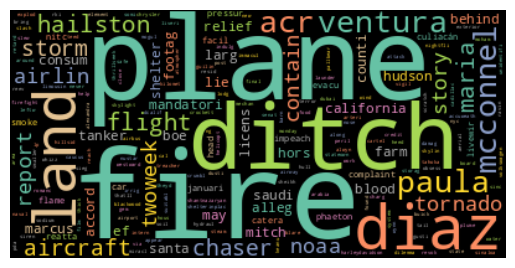

In [19]:
# skorzystajmy ze znanej juz biblioteki, by to lepiej zwizualizowac
def plot_vector(tf_idf_vector: dict[str, float]) -> None:
    wordcloud = WordCloud(random_state=42, background_color='black', colormap='Set2')
    wordcloud.generate_from_frequencies(frequencies=tf_idf_vector)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


plot_vector(user_vectors[test_users[0]])

## Część 5. - Rekomendacje dla użytkowników

In [20]:
# wykorzystujac wektory tresci i profile uzytkownikow,
#   wygeneruj liste k artykulow najlepiej dopasowanych do uzytkownika
#   pamietaj o odsianiu artykulow, ktore uzytkownik juz kliknal

def recommend(
    tf_idf: dict[str, dict[str, float]],
    user_id: str,
    news: dict[str, NewsEntry],
    users_history: dict[str, list[str]],
    user_vectors: dict[str, dict[str, float]],
    metric: Literal['euclidean', 'cosine'],
    k: int
) -> list[str]:
    user_vector: dict[str, float] = user_vectors[user_id]
    user_history: list[str] = users_history[user_id]
    nonuser_news_ids: filter[str] = filter(
        lambda n_id: n_id not in user_history, news.keys()
    )
    recommendation: dict[str, float] = {}  # [id_artykułu: dystans]

    for news_id in nonuser_news_ids:
        if news_id in user_history:
            continue
        recommendation[news_id] = calculate_vector_distance(user_vector, tf_idf[news_id], metric)

    k_recommended_news_ids: list[str] = sorted(
        [news_id for news_id in recommendation.keys()],
        key=lambda n_id: recommendation[n_id]
    )[:k]

    return k_recommended_news_ids


# dla wybranego uzytkownika, korzystajac z juz zaimplementowanych funkcji,
#   pokaz jego historie, profil (wordcloud) i rekomendacje

def __show_news(news_ids: list[str]) -> None:
    for news_id in news_ids:
        print_news_entry(news_id, news)


def show_user_history(user_history: list[str]) -> None:
    __show_news(user_history)


def show_user_recommendations(user_recommendations: list[str]) -> None:
    __show_news(user_recommendations)

In [21]:
test_user: str = test_users[3]

id: N45388
	title: College football Week 8 bowl projections: Baylor surges into New Year's Day 6
	text: Sporting News' Week 8 bowl projections saw a little movement, and Baylor and North Carolina each have joined the New Year's Day 6 discussion.
id: N14238
	title: College Football Rivalries: The Top Nicknames
	text: 
id: N28467
	title: Four-metre king cobra wrestled from sewer in Thailand
	text: A feisty four-metre (13-foot) king cobra was pulled from a sewer in southern Thailand in an hour-long operation, a rescue foundation said Tuesday, describing the reptile as one of the largest they had ever captured. Kritkamon said the snake was more than four metres long, weighed 15 kilos (33 pounds), and was the third-largest they had found.
id: N24724
	title: Humanitarian crisis unfolds as violence escalates in Syria
	text: In little more than a week, longstanding alliances have crumbled and old enemies have teamed up after the U.S. began pulling its forces out and Turkey invaded Syria
id: N5

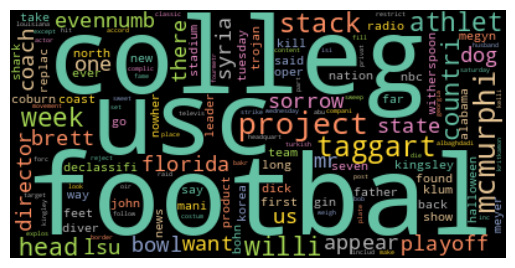

id: N58878
	title: Brett McMurphy's College Football Bowl Projections After Week 10
	text: It's going to be a fun bowl season for the Group of Five. The post Brett McMurphy's College Football Bowl Projections After Week 10 appeared first on Stadium.
id: N34147
	title: Brett McMurphy: Urban Meyer Is USC's Top Choice to Be Their Next Coach
	text: Urban Meyer is USC's top choice to be their next coach, according to Stadium College Football Insider Brett McMurphy.
id: N64513
	title: LSU, Ohio State, and Clemson control path to College Football Playoff, but who else does too?
	text: After a rather eventful day around the college football world, the big question is how did it all impact the College Football Playoff race. You would think that two of the top four teams falling on the first Saturday since the initial release of the College Football Playoff rankings would have a dramatic effect on Read more... The post LSU, Ohio State, and Clemson control path to College Football Playoff, but wh

In [22]:
show_user_history(users_history[test_user])
plot_vector(user_vectors[test_user])
show_user_recommendations(
    recommend(tf_idf, test_user, news, users_history, user_vectors, METRIC, k=5)
)

## Część 6. - Ocena jakości

In [23]:
# jaccard index to metryka podobienstwa zbiorow, lekko ja zmodyfikujemy
# przeciecie wektorow to minimum po kazdej wspolrzednej
# unia wektorow to maksimum po kazdej wspolrzednej
# jaccard index to iloraz sum tych dwoch wartosci

def jaccard(v1: dict[str, float], v2: dict[str, float]) -> float:
    unique_words: set[str] = set(chain(v1.keys(), v2.keys()))
    return (
        sum([
            min(v1.get(word, 0.0), v2.get(word, 0.0))
            for word in unique_words
        ])
        / sum([
            max(v1.get(word, 0.0), v2.get(word, 0.0))
            for word in unique_words
        ])
    )

In [24]:
# dla kazdego uzytkownika wygeneruj k-elementowa rekomendacje
# policz jaccard index miedzy wektorem uzytkownika a srednim wektorem elementow z rekomendacji
# porownaj wyniki dla dwoch roznych k i dwoch roznych metryk podobienstwa

def show_similarity(
    user_id: str,
    metric: Literal['euclidean', 'cosine']
) -> None:
    highest_k: int = 20

    recommendations: list[str] = recommend(
        tf_idf, user_id, news, users_history, user_vectors, metric, highest_k
    )
    user_vector: dict[str, float] = user_vectors[user_id]

    print(f'{metric.capitalize()} {(24 - len(metric) - 1) * "="}')
    for k in range(5, highest_k + 1, 5):
        recommendation_vector: dict[str, float] = calculate_average_vector(
            tf_idf, recommendations[:k]
        )
        print(
            f'Jaccard index@{k}:{(len(str(highest_k)) + 1 - len(str(k))) * " "}'
            f'{jaccard(user_vector, recommendation_vector):.4f}'
        )


show_similarity(test_user, 'euclidean')
print()
show_similarity(test_user, 'cosine')

Euclidean ==============
Jaccard index@5:  0.0055
Jaccard index@10: 0.0064
Jaccard index@15: 0.0106
Jaccard index@20: 0.0111

Cosine =================
Jaccard index@5:  0.0455
Jaccard index@10: 0.0581
Jaccard index@15: 0.0710
Jaccard index@20: 0.0904
